# BETO for detecting arjona vs bad *bunny*

<img src="https://www.lavanguardia.com/files/og_thumbnail/uploads/2020/08/04/5faa748c134a2.jpeg" width=300>

<img src="https://www.eluniverso.com/resizer/GHXc7soDkBedXDpSd0rTeyrnvyk=/1174x658/smart/filters:quality(70)/cloudfront-us-east-1.images.arcpublishing.com/eluniverso/X2NMNYP3EFFZLOTIG26NI2C47U.jpg" width=300>

In [1]:
!pip install -q transformers shap datasets==1.5.0

     |████████████████████████████████| 2.9 MB 5.0 MB/s 
     |████████████████████████████████| 356 kB 65.4 MB/s 
     |████████████████████████████████| 192 kB 68.2 MB/s 
     |████████████████████████████████| 243 kB 59.6 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 69 kB 8.0 MB/s 
     |████████████████████████████████| 123 kB 73.7 MB/s 
     |████████████████████████████████| 3.3 MB 50.9 MB/s 
     |████████████████████████████████| 636 kB 56.8 MB/s 
     |████████████████████████████████| 895 kB 62.0 MB/s 


In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
sns.set_theme()
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import AutoConfig
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import AutoTokenizer, TrainingArguments, Trainer
from datasets import load_dataset, Dataset
from datasets.utils.logging import set_verbosity_error
set_verbosity_error()
import shap

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

data from https://www.kaggle.com/paultimothymooney/poetry?select=Kanye_West.tx

In [15]:
data = []
max_lines = 2000
response = requests.get("https://raw.githubusercontent.com/davidbetancur8/Biomedica/master/ds_2021/03-modelacion/datos/badbunny.txt")
content = response.text.split("\n")
i = 0
for row in content:
  data.append([row.strip(), "badbunny"])
  i += 1
  if i == max_lines: break



response = requests.get("https://raw.githubusercontent.com/davidbetancur8/Biomedica/master/ds_2021/03-modelacion/datos/arjona.txt")
content = response.text.split("\n")
i = 0
for row in content:
  data.append([row.strip(), "arjona"])
  i += 1
  if i == max_lines: break
      
df = pd.DataFrame(data, columns=["text", "artist"])
le = preprocessing.LabelEncoder()
df['artist'] = le.fit_transform(df.artist.values)

In [16]:
df

,text,artist
0,"Yeh, yeh",1
1,Todavía yo te quiero,1
2,Pero sé que es un error,1
3,Porque ya tú no me quieres,1
4,Y sin ti me va mejor,1
...,...,...
3995,"por eso es que es un buen dia, para empezar.",0
3996,Porque hasta hoy he sido,0
3997,solo una ensarta de moleculas.,0
3998,"un sube y baja de la sangre,",0


## Some parameters

In [13]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
EPOCHS = 2
LEARNING_RATE = 1e-05

## Dataset


In [17]:
df["artist"].value_counts()

1    2000
0    2000
Name: artist, dtype: int64

In [25]:
df["labels"] = df["artist"]

In [18]:
model_name = 'dccuchile/bert-base-spanish-wwm-cased'
is_distil = "distil" in model_name
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name, num_labels=len(le.classes_))
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)
model.to(device)
print("Ok")

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

Ok


In [26]:
df.to_csv("train_data.csv", index=False)

In [27]:
dataset = load_dataset('csv', data_files='train_data.csv')
dataset

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-d296397a7ecf6457/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0. Subsequent calls will reuse this data.


DatasetDict({
    train: Dataset({
        features: ['text', 'artist', 'labels'],
        num_rows: 4000
    })
})

In [28]:
tokenizer_args = {"truncation": True,
                  "max_length": MAX_LEN,
                  "padding": "max_length",
                  "return_token_type_ids":not is_distil}


def encode(examples):
    return tokenizer(examples['text'], None, **tokenizer_args)

In [29]:
dataset = dataset.map(encode, batched=True)

In [30]:
columns = ['input_ids', 'token_type_ids', 'attention_mask', 'labels']
if is_distil:
    columns = ['input_ids', 'attention_mask', 'labels']
dataset.set_format(type='torch', columns=columns)
dataset['train'], dataset['validation'] = dataset['train'].train_test_split(.1).values()

# Trainning

In [32]:
args = TrainingArguments(
    "beto_songs",
    evaluation_strategy = "epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=VALID_BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,)

In [33]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": metrics.accuracy_score(labels, predictions),
            "f1_macro": metrics.f1_score(labels, predictions, average="macro")}

In [34]:
trainer = Trainer(
    model,
    args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
    )

In [35]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: artist, text.
***** Running training *****
  Num examples = 3600
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 900


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.099198,0.972500,0.972236


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: artist, text.
***** Running Evaluation *****
  Num examples = 400
  Batch size = 8
Saving model checkpoint to beto_songs/checkpoint-500
Configuration saved in beto_songs/checkpoint-500/config.json
Model weights saved in beto_songs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in beto_songs/checkpoint-500/tokenizer_config.json
Special tokens file saved in beto_songs/checkpoint-500/special_tokens_map.json


KeyboardInterrupt: ignored

# Revision de Validacion

In [36]:
preds_val = trainer.predict(dataset['validation'])

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: artist, text.
***** Running Prediction *****
  Num examples = 400
  Batch size = 8


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.099198,0.972500,0.972236


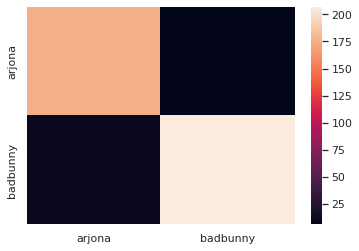

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(dataset['validation']["labels"], preds_val.predictions.argmax(axis=1))

sns.heatmap(cm, xticklabels=le.classes_, yticklabels=le.classes_)

# Predict


In [45]:
my_dict = {
    "text":["solo quiero dinero Yeh, yeh", "los hermosos hielos a traves de tu cuerpo celestial"]
}
dataset_predict = Dataset.from_dict(my_dict)
dataset_predict = dataset_predict.map(encode, batched=True)

In [46]:
trainer.predict(dataset_predict).predictions.argmax(axis=1)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2
  Batch size = 8


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.099198,0.972500,0.972236


array([1, 0])

In [44]:
def softmax(x, axis):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=axis) 

def sentences_prediction(predict_texts, axis):
    my_dict = {
        "text": predict_texts
    }
    dataset_predict = Dataset.from_dict(my_dict)
    dataset_predict = dataset_predict.map(encode, batched=True)
    preds = trainer.predict(dataset_predict).predictions
    return preds, softmax(preds, axis=axis)

def f(x):
    preds, _ = sentences_prediction(x, axis=0)
    scores = (np.exp(preds).T / np.exp(preds).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

In [50]:
# los hermosos hielos a traves de tu cuerpo celestial
# solo quiero dinero Yeh, yeh
sentence = ["los hermosos hielos a traves de tu cuerpo celestial"]
sentences_prediction(sentence,axis=1)[1][0]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 1
  Batch size = 8


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.099198,0.972500,0.972236


array([9.9960619e-01, 3.9383362e-04], dtype=float32)

In [51]:
explainer = shap.Explainer(f, tokenizer)
shap_values = explainer(sentence, fixed_context=1)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 1
  Batch size = 8


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.099198,0.972500,0.972236


The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 1
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tex

In [52]:
shap.plots.text(shap_values[0])